# Imports

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2
from src import *
import numpy as np
import matplotlib.pyplot as plt

# Signal

In [5]:
dim = (32, 32)

# Sparse signal parameters
sparse_range = (2, 6)
density = 0.005

# Smooth signal parameters
smooth_range = (0, 2)
sigmas_range = (2e-2, 2e-1)
nb_gaussian = 100

# Seed
seed = None
np.random.seed(seed)

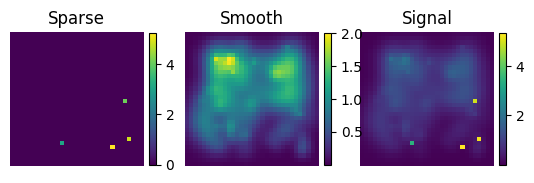

In [4]:
sparse_signal = compute_sparse(dim, sparse_range, density, seed)
smooth_signal = compute_smooth(dim, smooth_range, sigmas_range, nb_gaussian)

signal = sparse_signal + smooth_signal 
plot_signal(sparse_signal,smooth_signal,signal)

In [7]:
L = 1
theta = 0
phi = non_uni_FFT(dim, L, theta)

x0 = signal.reshape(-1)
y0 = pxu.view_as_complex(phi.apply(x0))

pnsr = np.inf
y = compute_y(y0, pnsr)

NameError: name 'non_uni_FFT' is not defined

In [6]:
import numpy as np
import pyxu.util as pxu
from pyxu.abc.operator import LinOp
from pyxu.operator.linop.base import NullFunc
from pyxu.operator.func.norm import SquaredL2Norm, L1Norm
from pyxu.operator.blocks import hstack
from pyxu.opt.solver import PGD
from pyxu.opt.stop import AbsError, RelError


def solve(y, phi, lambda1, lambda2, l2operator=None):
    stack = hstack([phi, phi])
    l22_loss = (1 / 2) * SquaredL2Norm(dim=phi.shape[0]).asloss(pxu.view_as_real(y))
    F = l22_loss * stack

    if lambda2 != 0.0:
        if isinstance(l2operator, LinOp):
            L = lambda2 * SquaredL2Norm(l2operator.shape[0]) * l2operator
        else:
            L = lambda2 * SquaredL2Norm(phi.shape[1])

        F = F + hstack([NullFunc(phi.shape[1]), L])
    F.diff_lipschitz = F.estimate_diff_lipschitz()

    if lambda1 == 0.0:
        G = NullFunc(2 * phi.shape[1])
    else:
        G = hstack([lambda1 * L1Norm(phi.shape[1]), NullFunc(phi.shape[1])])

    pgd = PGD(f=F, g=G, verbosity=50)
    stopper = AbsError(eps=1e-5, var=None, f=pgd.objective_func)
    print(np.ones(2 * phi.shape[1]).shape)
    pgd.fit(x0=np.ones(2 * phi.shape[1]), stop_crit=stopper)
    print(pgd._mstate.keys())
    x = pgd.solution()
    x1 = x[: phi.shape[1]]
    x2 = x[phi.shape[1] :]
    return x1, x2

In [9]:
lambda1 = 1
lambda2 = 1
stack = hstack([phi, phi])
l22_loss = (1 / 2) * SquaredL2Norm(dim=phi.shape[0]).asloss(pxu.view_as_real(y))
F = l22_loss * stack

if lambda2 != 0.0:
    L = lambda2 * SquaredL2Norm(phi.shape[1])

F = F + hstack([NullFunc(phi.shape[1]), L])
F.diff_lipschitz = F.estimate_diff_lipschitz()

if lambda1 == 0.0:
    G = NullFunc(2 * phi.shape[1])
else:
    G = hstack([lambda1 * L1Norm(phi.shape[1]), NullFunc(phi.shape[1])])

pgd = PGD(f=F, g=G, verbosity=50)
stopper = AbsError(eps=500, var="x", f=F+G) & RelError(eps=1e-4)
print(np.ones(2 * phi.shape[1]).shape)
pgd.fit(x0=np.ones(2 * phi.shape[1]), stop_crit=stopper)
print(pgd._mstate.keys())
x = pgd.solution()
x1 = x[: phi.shape[1]]
x2 = x[phi.shape[1] :]


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyxu/abc/arithmetic.py:639: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t2 = float(self._op.apply(self._cst))


(2048,)
INFO -- [2023-10-09 20:16:58.826131] Iteration 0
	iteration: 0
	AbsError[x]: 1171412.8447624368
	RelError[x]: 0.0
INFO -- [2023-10-09 20:16:59.623499] Iteration 50
	iteration: 50
	AbsError[x]: 6271.344228454654
	RelError[x]: 0.008428789891491394
INFO -- [2023-10-09 20:17:00.386534] Iteration 100
	iteration: 100
	AbsError[x]: 995.040434276045
	RelError[x]: 0.0017260616568109488
INFO -- [2023-10-09 20:17:01.068124] Iteration 150
	iteration: 150
	AbsError[x]: 652.0794880445297
	RelError[x]: 0.0009184466428897104
INFO -- [2023-10-09 20:17:01.754272] Iteration 200
	iteration: 200
	AbsError[x]: 551.646650192262
	RelError[x]: 0.0006283790258195859
INFO -- [2023-10-09 20:17:02.439449] Iteration 250
	iteration: 250
	AbsError[x]: 507.2134288704214
	RelError[x]: 0.0004853811449026066
INFO -- [2023-10-09 20:17:03.127265] Iteration 300
	iteration: 300
	AbsError[x]: 482.64566467113696
	RelError[x]: 0.00040228916920583707
INFO -- [2023-10-09 20:17:03.865638] Iteration 350
	iteration: 350
	Abs

sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x153f50f40>


160.01581612819174


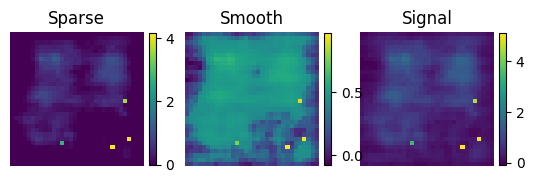

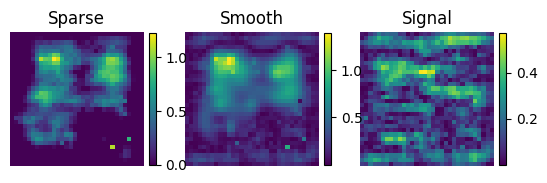

In [10]:
sparse_rcstr, smooth_rcstr, signal_rcstr = map(
    lambda x: x.reshape(dim), (x1, x2, x1 + x2)
)
plot_signal(sparse_rcstr, smooth_rcstr, signal_rcstr)
plot_signal(
    np.abs(sparse_rcstr - sparse_signal),
    np.abs(smooth_rcstr - smooth_signal),
    np.abs(signal_rcstr - signal),
)
print(np.abs(signal_rcstr - signal).sum())

array([0.00286915, 0.00531335, 0.00944373, 0.01610932, 0.02637363,
       0.04144018, 0.06249312, 0.09044858, 0.12564067, 0.1675011 ,
       0.21432066, 0.26318997, 0.31019413, 0.3508785 , 0.38092447,
       0.39689893, 0.39689893, 0.38092447, 0.3508785 , 0.31019413,
       0.26318997, 0.21432066, 0.1675011 , 0.12564067, 0.09044858,
       0.06249312, 0.04144018, 0.02637363, 0.01610932, 0.00944373,
       0.00531335, 0.00286915])

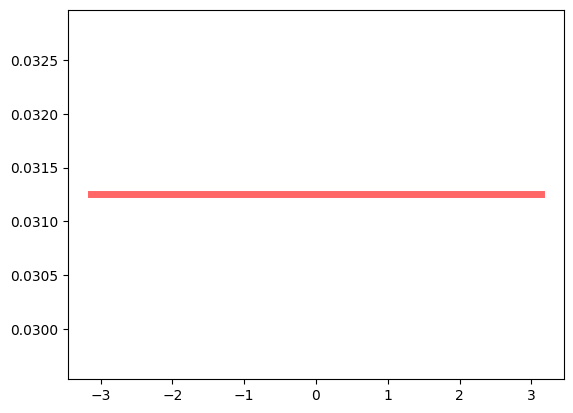

In [11]:
# plt.imshow(p.random.multivariate_normal([0, 0], [[1, 0], [0, 1]], ))
p_gaussian = [
    np.exp(-((3 * (x1 - dim[0]) / dim[0]) ** 2 + (3 * x2 / dim[1]) ** 2)) / (2 * np.pi)
    for x1 in range(dim[0])
    for x2 in range(dim[1])
]
np.sum(p_gaussian)
import numpy as np


def makeGaussian2(
    x_center=0, y_center=0, theta=0, sigma_x=10, sigma_y=10, x_size=640, y_size=480
):
    # x_center and y_center will be the center of the gaussian, theta will be the rotation angle
    # sigma_x and sigma_y will be the stdevs in the x and y axis before rotation
    # x_size and y_size give the size of the frame

    theta = 2 * np.pi * theta / 360
    x = np.arange(0, x_size, 1, float)
    y = np.arange(0, y_size, 1, float)
    y = y[:, np.newaxis]
    sx = sigma_x
    sy = sigma_y
    x0 = x_center
    y0 = y_center

    # rotation
    a = np.cos(theta) * x - np.sin(theta) * y
    b = np.sin(theta) * x + np.cos(theta) * y
    a0 = np.cos(theta) * x0 - np.sin(theta) * y0
    b0 = np.sin(theta) * x0 + np.cos(theta) * y0

    return np.exp(
        -(((a - a0) ** 2) / (2 * (sx**2)) + ((b - b0) ** 2) / (2 * (sy**2)))
    )


from scipy.stats import norm

x = np.linspace(-np.pi, np.pi, dim[0])
plt.plot(
    x,
    theta * norm.pdf(x, scale=dim[0] / 6) / np.sum(norm.pdf(x, scale=dim[0] / 6))
    + (1 - theta) * 1 / dim[0] * np.ones_like(x),
    "r-",
    lw=5,
    alpha=0.6,
    label="norm pdf",
)
np.sum(
    theta * norm.pdf(x, scale=dim[0] / 6) / np.sum(norm.pdf(x, scale=dim[0] / 6))
    + (1 - theta) * 1 / dim[0] * np.ones_like(x)
)
from scipy.stats import norm

norm.ppf(0.005)
norm.pdf(x)

(32, 16)


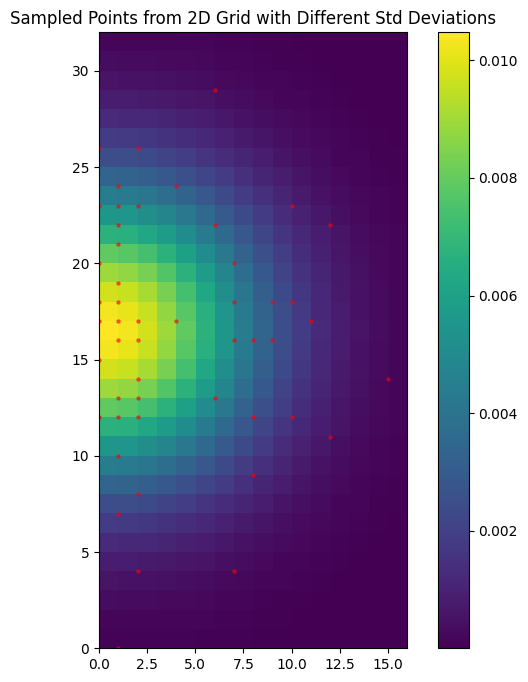

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Define grid size and standard deviations for X and Y dimensions
grid_size = (16,32) # Size of the grid
std_dev_x = dim[0]/6  # Standard deviation for the X dimension
std_dev_y = dim[1]/6 # Standard deviation for the Y dimension

# Create a grid of coordinates
x, y = np.meshgrid(np.arange(grid_size[0]), np.arange(grid_size[1]))

# Calculate the probability density function (PDF) of the normal distribution
pdf_x = np.exp(-0.5 * (x** 2) / std_dev_x**2)
pdf_y = np.exp(-0.5 * ((y - grid_size[1] / 2) ** 2) / std_dev_y**2)
pdf = pdf_x * pdf_y  
print(pdf.shape)
pdf /= (2 * np.pi * std_dev_x * std_dev_y)

# Normalize the PDF to make it a valid probability distribution
pdf /= pdf.sum()

# Sample points from the grid according to the PDF without duplicates
num_samples = 50  # Number of points to sample
sampled_indices = np.random.choice(grid_size[0] * grid_size[1], num_samples, p=pdf.T.ravel(), replace=False)
sampled_points = np.unravel_index(sampled_indices, grid_size)

# Plot the sampled points
plt.figure(figsize=(8, 8))
plt.scatter(sampled_points[0], sampled_points[1], s=5, color='red', alpha=0.5)
plt.imshow(pdf, cmap='viridis', extent=(0, grid_size[0], 0, grid_size[1]), origin='lower')
plt.colorbar()
plt.title(f'Sampled Points from 2D Grid with Different Std Deviations')
plt.show()

In [17]:
nb_gaussian = 10
nb_uniform = 10
samples = set()
while len(samples) < nb_gaussian:
    x = np.pi * (2 * np.random.choice(dim[0]) / dim[0] - 1)
    y = np.pi * (2 * np.random.choice(dim[1]) / dim[1] - 1)
    samples.add((x, y))
while len(samples) - nb_gaussian < nb_uniform:
    x = np.pi * (2 * np.random.choice(dim[0]) / dim[0] - 1)
    y = np.pi * (2 * np.random.choice(dim[1]) / dim[1] - 1)
    samples.add((x, y))
samples = np.array(samples)

array({(4, 0), (23, 10), (28, 3), (5, 7), (28, 15), (14, 28), (30, 15), (10, 12), (9, 29), (29, 1), (21, 0), (15, 29), (31, 19), (19, 5), (5, 27), (18, 0), (18, 12), (20, 18), (19, 4), (11, 15)},
      dtype=object)

In [ ]:
# L = 1.0
# theta = 0.5
# op = NuFFT(dim,L,theta, on_grid=True)

# x0 = signal.reshape(-1)
# y0 = op(x0)

# pnsr = 50
# y = compute_y(y0, pnsr)

In [6]:
a = set((1,3))
b = a.copy()
a.add((2,4))
print(a,b)

{1, (2, 4), 3} {1, 3}


In [12]:
import numpy as np
if np.array([1]).size:
    print("hi")

hi


In [31]:
def gaussian_pdf(size: int) -> np.ndarray:
    """
    Generate a Gaussian probability density function.

    Args:
        size (int): Size of the probability density function.

    Returns:
        np.ndarray: Gaussian probability density function.
    """
    std_dev = size / 8
    pdf = np.exp(-0.5 * ((np.arange(size) - size // 2) ** 2) / (std_dev**2))
    return pdf / pdf.sum()

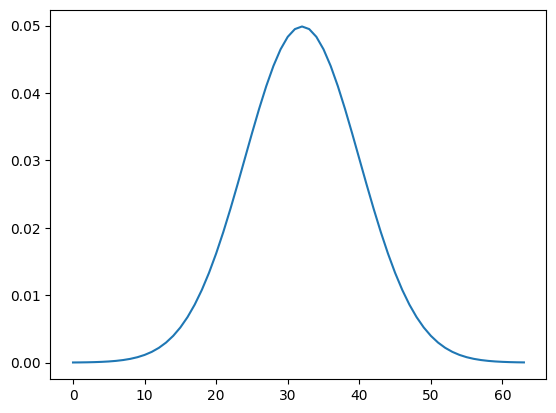

In [32]:
plt.plot(gaussian_pdf(64))

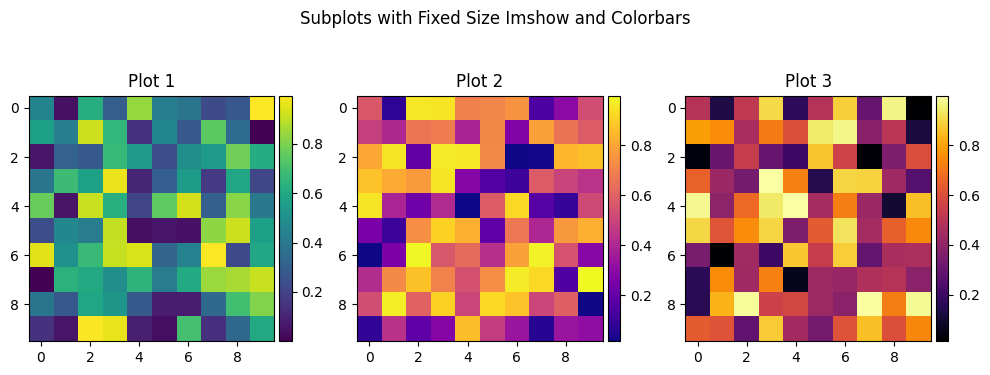

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Generate some example data for the subplots
data1 = np.random.rand(10, 10)
data2 = np.random.rand(10, 10)
data3 = np.random.rand(10, 10)

# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

# Define the positions and sizes of the subplots
subplot_params = [{'position': [0.1, 0.15, 0.25, 0.7]},
                  {'position': [0.4, 0.15, 0.25, 0.7]},
                  {'position': [0.7, 0.15, 0.25, 0.7]}]

# Create the first subplot
im1 = axs[0].imshow(data1, cmap='viridis')
axs[0].set_title('Plot 1')
divider = make_axes_locatable(axs[0])
cax1 = divider.append_axes("right", size="5%", pad=0.05)
cbar1 = plt.colorbar(im1, cax=cax1)

# Create the second subplot
im2 = axs[1].imshow(data2, cmap='plasma')
axs[1].set_title('Plot 2')
divider = make_axes_locatable(axs[1])
cax2 = divider.append_axes("right", size="5%", pad=0.05)
cbar2 = plt.colorbar(im2, cax=cax2)

# Create the third subplot
im3 = axs[2].imshow(data3, cmap='inferno')
axs[2].set_title('Plot 3')
divider = make_axes_locatable(axs[2])
cax3 = divider.append_axes("right", size="5%", pad=0.05)
cbar3 = plt.colorbar(im3, cax=cax3)

# Add an overall title for the figure
fig.suptitle('Subplots with Fixed Size Imshow and Colorbars')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()


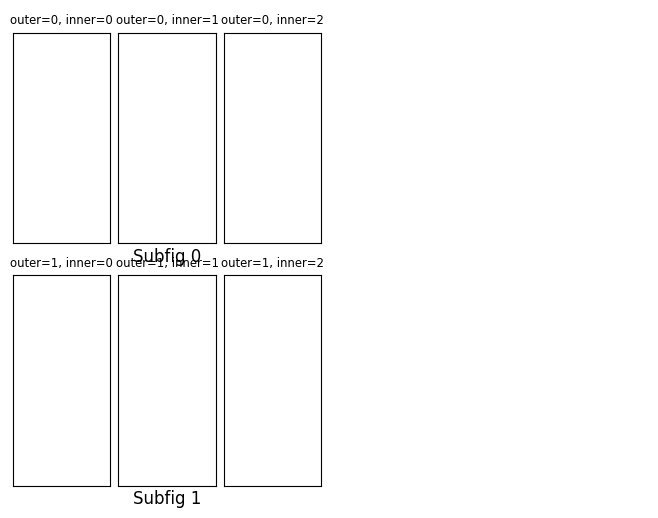

In [16]:
def plot_results(original_signal, reconstructed_signal, op):
    fig = plt.figure(constrained_layout=True)

    subfigs = fig.subfigures(1, 2, width_ratios=)
    subfigs_signals = subfigs[0].subfigures(2,1)


    for outerind, subfig in enumerate(subfigs_signals.flat):
        subfig.suptitle(f'Subfig {outerind}', y=0)
        axs = subfig.subplots(1,3)
        for innerind, ax in enumerate(axs.flat):
            ax.set_title(f'outer={outerind}, inner={innerind}', fontsize='small')
            ax.set_xticks([])
            ax.set_yticks([])
    
    plt.show()



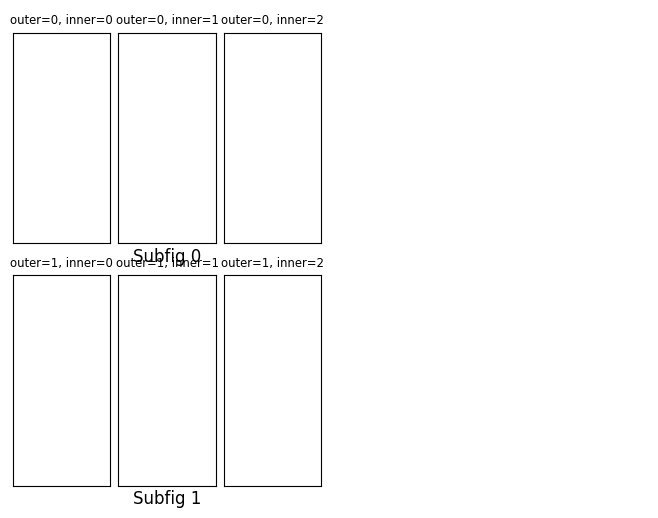

In [9]:
import matplotlib.pyplot as plt

fig = plt.figure(constrained_layout=True)

subfigs = fig.subfigures(1, 2)
subfigs_ = subfigs[0].subfigures(2,1)


for outerind, subfig in enumerate(subfigs_.flat):
    subfig.suptitle(f'Subfig {outerind}', y=0)
    axs = subfig.subplots(1,3)
    for innerind, ax in enumerate(axs.flat):
        ax.set_title(f'outer={outerind}, inner={innerind}', fontsize='small')
        ax.set_xticks([])
        ax.set_yticks([])
 
plt.show()